In [1]:
import numpy as np
import scipy
import time
import math
from scipy.stats import norm

import mystic
from mystic.solvers import DifferentialEvolutionSolver, diffev2
from mystic.strategy import Best1Bin
from mystic.monitors import Monitor,VerboseMonitor

from copy import deepcopy

from Tomography import *

from NestedForLoop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch
from Efficiencies import finding_file, get_channels_eff, set_raw_counts
from Optimization import Optimizer, function_fidelity, FidelityResults
from constants import *

from DensityMatrix import DensityMatrix

from pathlib import Path
import fnmatch

In [10]:
######################################################################################################
#----- COUNTING THE FILES AND SAVING THEM IN AN ARRAY TO MAKES THE REST OF THE ANALYSIS EASIER -------
######################################################################################################

# n_files=0
# working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
# #working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringMaliciousBPF\BPF202205262200"
# os.chdir(working_dir)

# filenames = [i for i in glob.glob("Channel*")]
# #filenames = [i for i in glob.glob("StateTomography*")]
# filenames.sort(key=os.path.getmtime)

# index_to_file = {}

# for index, filename in enumerate(filenames):
#     os.chdir(f"{working_dir}\\{filename}")
#     filenames_aux=[i for i in glob.glob("StateTomography*")]
#     for index_second, filenames_aux_second in enumerate(filenames_aux):
#         index_to_file[n_files] = f"{filename}\\{filenames_aux_second}"
#         n_files+=1
# os.chdir(working_dir)

In [2]:
######################################################################################################
#----- COUNTING THE FILES AND SAVING THEM IN AN ARRAY TO MAKES THE REST OF THE ANALYSIS EASIER -------
######################################################################################################

n_files=0
working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\StateTomographies\StabilityWeekEnd21052022"
os.chdir(working_dir)

filenames = [i for i in glob.glob("StateTomography*")]

index_to_file = {}

for index, filename in enumerate(filenames):
    index_to_file[n_files] = f"{filename}"
    n_files+=1

In [3]:
os.chdir(working_dir)
qubit_number=2

# state_after=[]
# state_after_file=[]

# state_before=[]
# state_before_file=[]
state = []
xp_counts_corrected_with_eff=[]

#####################################################################
#---------------------- STATE TOMOGRAPHY ----------------------------
#####################################################################

for index in range(len(index_to_file)):
    os.chdir(f"{working_dir}\\{index_to_file[index]}\\StateTomo")
    datafiles=[i for i in glob.glob("*")]
                
    ### Calculating the efficiencies of each detector
    efficiencies=get_channels_eff(datafiles, os.getcwd())

    ### Opening the data files and writing the data in counts_aux array
    counts_aux=set_raw_counts(datafiles, qubit_number, os.getcwd())
    xp_counts=np.array(np.transpose(counts_aux))

    statetomo=LRETomography(int(qubit_number), xp_counts, 'C:\\Users\\LauraMartins\\Documents\\PhD\\Lab\\Code\\Tomographies')
    statetomo.run(correct_eff=efficiencies, print_nc=False)
    xp_counts_corrected_with_eff.append(statetomo.xp_counts)
    
    state.append(DensityMatrix(statetomo.quantum_state.get_density_matrix()))
    print('\n Fast maximum likelihood estimation: \n', state[-1], '\n')

    ### The 'e' and 'r' serve to distinguish between tomography before and after, respectively
    ### We want to save them in different arrays because we need them for different things
#     if index_to_file[index][-8]=='e':
#         state_before.append(DensityMatrix(statetomo.quantum_state.get_density_matrix()))
#         state_before_file.append(index_to_file[index])
#         #print('\n Fast maximum likelihood estimation: \n', state_before[-1], '\n')

#     elif index_to_file[index][-8]=='r':
#         state_after.append(DensityMatrix(statetomo.quantum_state.get_density_matrix()))
#         state_after_file.append(index_to_file[index])
#         #print('\n Fast maximum likelihood estimation: \n', state_after[-1], '\n')
            


 Fast maximum likelihood estimation: 
 array([[ 6.96629423e-04-7.15643540e-19j,  2.39355034e-03+4.15338101e-03j,
        -4.27741655e-04+5.76460856e-03j, -8.03839382e-05+1.90515369e-03j],
       [ 2.39355034e-03-4.15338101e-03j,  4.87763969e-01-2.29513705e-16j,
         4.88859845e-01+3.70332296e-02j, -6.64588634e-03+2.56433523e-03j],
       [-4.27741655e-04-5.76460856e-03j,  4.88859845e-01-3.70332296e-02j,
         5.05585023e-01+2.28687442e-16j, -2.10401048e-03-4.40494410e-03j],
       [-8.03839382e-05-1.90515369e-03j, -6.64588634e-03-2.56433523e-03j,
        -2.10401048e-03+4.40494410e-03j,  5.95437898e-03+1.54190699e-18j]]) 


 Fast maximum likelihood estimation: 
 array([[ 1.09276899e-03-7.58671390e-19j,  3.07647083e-03+9.62961377e-03j,
         3.60470551e-03+7.78198983e-03j, -1.39682444e-04-5.07823444e-04j],
       [ 3.07647083e-03-9.62961377e-03j,  4.98734234e-01-8.28196508e-17j,
         4.94639388e-01+9.60268575e-03j, -5.55396814e-03-4.85786329e-03j],
       [ 3.60470551e-03


 Fast maximum likelihood estimation: 
 array([[ 4.73176966e-04+3.12530003e-19j,  3.74658630e-03+7.25282892e-03j,
         1.48792224e-03+8.45954077e-03j, -1.09278287e-04+1.25062161e-03j],
       [ 3.74658630e-03-7.25282892e-03j,  4.88841613e-01-1.34389373e-17j,
         4.89823971e-01+3.47544951e-02j, -7.92834295e-03-1.02647766e-03j],
       [ 1.48792224e-03-8.45954077e-03j,  4.89823971e-01-3.47544951e-02j,
         5.04920663e-01+1.29616624e-17j, -3.90402213e-03-7.44105037e-03j],
       [-1.09278287e-04-1.25062161e-03j, -7.92834295e-03+1.02647766e-03j,
        -3.90402213e-03+7.44105037e-03j,  5.76454762e-03+1.64744878e-19j]]) 


 Fast maximum likelihood estimation: 
 array([[ 9.82254368e-04-2.71255761e-19j,  3.26091005e-03+6.33007133e-03j,
        -6.07663896e-06+8.20682033e-03j, -1.84235677e-04+1.97830966e-03j],
       [ 3.26091005e-03-6.33007133e-03j,  4.88509574e-01-9.01322490e-17j,
         4.89663719e-01+3.62053639e-02j, -6.97320984e-03-1.62442252e-03j],
       [-6.07663896e-06

In [4]:
######################################
#-- DEFINING THE TARGET BELL STATE ---
######################################

#bell=(np.array([1,0,0,0])+np.array([0,0,0,1]))/np.sqrt(2)
#bell=(np.array([1,0,0,0])-np.array([0,0,0,1]))/np.sqrt(2)
bell=(np.array([0,1,0,0])+np.array([0,0,1,0]))/np.sqrt(2)
#bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

#for index in range(len(state)):
#    print(np.real(np.round(state[index].fidelity_to_pure(bell),5)))

In [13]:
# for index in range(len(state_after)):
#     print(np.real(np.round(state_after[index].fidelity_to_pure(bell),5)))

In [14]:
##########################################################
#----- OPTIMIZATION OF MAX FIDELITY UP TO UNITARIES ------
##########################################################

# fid=np.zeros((n_files))
# optimized_matrix=np.zeros((n_files,2**qubit_number,2**qubit_number), dtype='complex')

# guess=np.array([0, 0, 0, 0, 0, 0])
# bounds=[(-np.pi,np.pi)]*6
# results = []

# opt=Optimizer(guess, function_fidelity, results=FidelityResults)

# for index in range(len(state_before)):
#     result=opt.optimize(state_before[index], bell, bounds=bounds)
#     results.append(result)

In [15]:
# for index in range(len(state_before)):
#     print(np.real(np.round(results[index].optimized_state.fidelity_to_pure(bell),5)))

In [5]:
##########################################################
#---------------- CALCULATING THE ERRORS -----------------
##########################################################
"""
Next time we should measure the efficiencies seperately to the data (each data file shoudn't have different channel efficiencies)
xp_counts should be a class from the start and then it would be updated
"""
error_runs=1000

mu=np.zeros((n_files))
std=np.zeros((n_files))

states=state
for index in range(len(states)):

    dm = states[index]
    dm.calculate_errors(xp_counts_corrected_with_eff[index].counts_array, error_runs, bell)
    
    print('index, fidelity, fidelity_mean, fidelity_std: ',
          index, np.round(states[index].fidelity_to_pure(bell),5), np.round(dm.mu,5), np.round(dm.std,5))

index, fidelity, fidelity_mean, fidelity_std:  0 (0.98553+0j) 0.98409 0.00029
index, fidelity, fidelity_mean, fidelity_std:  1 (0.99227+0j) 0.98722 0.00033
index, fidelity, fidelity_mean, fidelity_std:  2 (0.9871-0j) 0.98466 0.00031
index, fidelity, fidelity_mean, fidelity_std:  3 (0.98695+0j) 0.98248 0.0003
index, fidelity, fidelity_mean, fidelity_std:  4 (0.98748+0j) 0.98328 0.00029
index, fidelity, fidelity_mean, fidelity_std:  5 (0.9871+0j) 0.98272 0.0003
index, fidelity, fidelity_mean, fidelity_std:  6 (0.98676+0j) 0.98306 0.00031
index, fidelity, fidelity_mean, fidelity_std:  7 (0.98659+0j) 0.98332 0.0003
index, fidelity, fidelity_mean, fidelity_std:  8 (0.98689-0j) 0.98368 0.00029
index, fidelity, fidelity_mean, fidelity_std:  9 (0.98645-0j) 0.98321 0.00031
index, fidelity, fidelity_mean, fidelity_std:  10 (0.98649-0j) 0.98296 0.0003
index, fidelity, fidelity_mean, fidelity_std:  11 (0.98636+0j) 0.98199 0.0003
index, fidelity, fidelity_mean, fidelity_std:  12 (0.98645-0j) 0.9819

In [18]:
# bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
# bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

# dm = states[2]
# dm.calculate_errors(xp_counts_corrected_with_eff[2].counts_array, error_runs, bell)

# print('index, fidelity, fidelity_mean, fidelity_std: ',
#           2, np.real(np.round(states[2].fidelity_to_pure(bell),5)), np.round(dm.mu,5), np.round(dm.std,5))

Text(0.5, 1.0, 'Stability of the entanglement source')

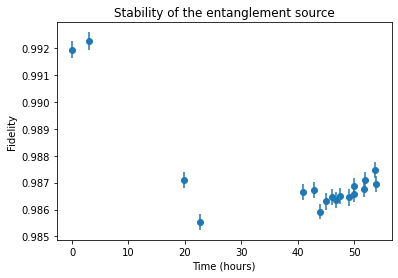

In [31]:
time=[]
ydata=np.zeros(len(states))
yerror=np.zeros(len(states))

for j in range(len(index_to_file)):
    time.append(int(index_to_file[j][-2:])/24+int(index_to_file[j][-4:-2])+24*int(index_to_file[j][-6:-4]))
first=np.min(time)

time=time-np.array([first]*len(index_to_file))
xdata=time
for index in range(len(states)):
    ydata[index]=np.real(np.round(states[index].fidelity_to_pure(bell),5))
    yerror[index]=np.round(states[index].std,5)

plt.errorbar(xdata, ydata, yerror, fmt='o', label='data')
plt.ylabel('Fidelity')
plt.xlabel('Time (hours)')
plt.title('Stability of the entanglement source')

In [19]:
##########################################################
#------------ WRITING THE DATA IN AN EXCEL ---------------
##########################################################

import xlsxwriter
#working_dir=r"G:\Other computers\Mon ordinateur\ChannelCertification\SteeringHonest"
os.chdir(working_dir)

workbook = xlsxwriter.Workbook('fidelities_after_channel_errors.xlsx') ### We should write this in another place
 
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'Number')
worksheet.write('B1', 'Folder')
worksheet.write('C1', 'Fidelity')
worksheet.write('D1', 'Fidelity_mean')
worksheet.write('E1', 'Fidelity_uncertainty')

counter=0
for index in range(len(state_before)):
    worksheet.write('A'+str(counter+2), counter)
    worksheet.write('B'+str(counter+2), state_after_file[index])
    worksheet.write('C'+str(counter+2), np.real(np.round(states[index].fidelity_to_pure(bell),5)))
    worksheet.write('D'+str(counter+2), np.real(np.round(states[index].mu,5)))
    worksheet.write('E'+str(counter+2), np.real(np.round(states[index].std,5)))
    counter+=1
        
workbook.close()

In [ ]:
### IF WE WANT TO CHECK THE FIT TO THE UNCERTARTAINTY
### Then we need to calculate the statistic on these simulated fidelities and calculate the standart deviation
### This will be our uncertainty due to statistical errors
def count_elements(seq) -> dict:
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(fidelity_sim)
#print(counted)
bin_numb = len(counted)
errorbar_x=np.array(list(counted))
errorbar_y=np.zeros((bin_numb), dtype=int)

for i in range(bin_numb):
    errorbar_y[i]=counted[errorbar_x[i]]
    
#print(errorbar_x)
#print(errorbar_y)
    
def Gauss(x, A, mu, sigm):
    y = A*np.exp(-((x-mu)/sigm)**2/2)
    return y

mu, std = norm.fit(fidelity_sim)
print(mu, std)
parameters, covariance = curve_fit(Gauss, xdata=errorbar_x[-1], ydata=errorbar_y[:-1], bounds=[(0,0.99007,1e-4),(60,0.9903,0.0002)])
fit_A = parameters[0]
fit_B = parameters[1]
fit_C = parameters[2]
print(fit_A, fit_B, fit_C)

xdata= x = np.linspace(0.989, 0.991, 100)
fit_y = Gauss(xdata, fit_A, fit_B, fit_C)
plt.plot(errorbar_x[:-1], errorbar_y[:-1], 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()